# Introduction

Recall that the [Grouped Recall model 1](../Grouped_Recall_1/Grouped_Recall_Model_1.ipynb) issued an explicit response for each outcome of a memory retrieval request, including a retrieval failure. Knowing all of this information made it relatively easy to recontruct the retrieval process from the data. In this tutorial, we will develop a variation of that model in which responses for retrieval failures are omitted. This minor change in the response rule leads to a more complex likelihood function because the position of retrieval failures within the sequence of retrieval attempts is no longer known. For example, if 8 out of 9 reponses were observed, a retrieval failure could have occured during any of the 9 retrieval attemps. As a reult, it is necessary to marginalize over the entire set of the possible orders in which the retrieval failures could have occured. Aside from this difference, many of the details about the task and model are the same as those for Grouped Recall 1.  

# Grouped Recall Task

The group recall task is a variation of the serial recall task in which items are organized hierarchically into groups. In this version of the task, the goal is to retrieve nine items in the originally presented order, which are organized into three groups of three. For ease of presentation, the items are ascending integers: (1,2,3), (4,5,6), (7,8,9). Of course, in practice, the items would not follow a simple counting rule. 


# Grouped Recall Model 2

The grouped recall model encodes items with a group and position id and uses the group and position id as retrieval cues for recalling the itmes. The strategy is quite simple: the model iterates through the group and position ids in ascending order, similar to a nested for loop:

In [1]:
for group in 1:3
    for position in 1:3
        println("retrieval request: group $group position $position")
    end
end

retrieval request: group 1 position 1
retrieval request: group 1 position 2
retrieval request: group 1 position 3
retrieval request: group 2 position 1
retrieval request: group 2 position 2
retrieval request: group 2 position 3
retrieval request: group 3 position 1
retrieval request: group 3 position 2
retrieval request: group 3 position 3


Upon retrieving a chunk, the model responds according to the value in the number slot. However, if a retrieval failure occurs, no response is recorded. The only indication that a retrieval failure occured is that the data will contain fewer than 9 responses. 

## Declarative memory

Declarative memory $M$ consists of a set of nine chunks, with slot set $Q = \{\textrm{group, position, retrieved, number}\}$. The values stored in the group and position slots index the group and position id, which encode information concerning order and serves as retrieval cues. The value stored in the number slot is the number to be remembered. The value stored in the slot called retrieved indicates whether the chunk has been previously retrieved. 


## Retrieval Request

On trial $i$, the retrieval request is defined as 

\begin{align}
    \mathbf{r}_i = \rm \{(position,v_1),(group, v_2), (retrieved,false)\}
\end{align}

where the corresponding slot set for the retrieval request is $Q_r = \rm \{position,group, retrieved\}$. 

## Inhibition of Return

Inhibition of return functions the same as with  [Serial Recall Model 1](../../../Tutorial_Models/Unit3/Serial_Recall_1/Serial_Recall_Model_1.ipynb). Once any chunk $m$ is marked as $c_m(\rm retrieved) = \textrm{true}$, it cannot be retrieved again. The set of chunks eligible for retrieval is defined as:

\begin{align}
    R = \{\mathbf{c}_m \in M: c_m(\rm retrieved) = \textrm{false}\}
\end{align}


## Activation

Activation for $\mathbf{c}_m \in R$ is given by the following equation:

\begin{align}
    a_{m} = \textrm{blc} + \rho_m + \epsilon_m
\end{align}


where the term blc represents base level constant, the term $\rho_m$ represents activation from partial matching, and $\epsilon \sim \textrm{Normal}(0, \sigma)$. Partial matching is given as:

\begin{equation}\label{eq:penalty}
\rho_m  = \delta \sum_{q \in Q_r}| c_m(q) - r_i(q) | 
\end{equation}

In the partial matching function above, the penalty for mismatching is the absolute difference between the request and the chunk. The distance gradient is modulated by mismatch penality parameter $\delta$. 

## Response mapping

Let $y_i \in \{1,2, \dots 9 \}, \forall_i$ be the set possible responses. Thus, the response for trial $i$ is $y_i  = c_r(\textrm{number})$.


## Response Probability

Let chunk $r$ be the retrieved chunk. The probability of $y_i$ is given by the soft max function:

\begin{align}
     \Pr(Y_i = y_i \mid \delta ;\mathbf{r}_i ) = \frac{e^{\frac{\mu_{r}}{\sigma}}}{\sum_{\mathbf{c}_k \in R} e^{\frac{\mu_k}{\sigma}} + e^{\frac{\mu_{m^\prime}}{\sigma}}}
\end{align}

where $\mu_m$ is the expected activation of chunk $m$ and $\sigma$ governs the amount of activation noise. 

### Marginalization

As previously noted, the position of retrieval failures within a sequence of memory retrievals is a random variable because responses for retrieval failures are omitted. As a result, we must marginalize over all possible sequences of retrievals and retrieval failures. We will use a concept from combinatorics called multisets to enumerate all of the possible orders. A multiset is a special type of set that may contain duplicate elements. For example $\mathbf{a} = \{a,a,b,c,c\}$ is a multiset. Sometimes multisets are called stars and bars, owing to the fact that the sequences are often represented as a series of astriks and verticle lines: * * | *. We will load the required packages and provide an example of enumerating multisets.

In [2]:
cd(@__DIR__)
# load the package manager
using Pkg
# activate the project environment
Pkg.activate("../../../")
# load the required packages
using Turing, StatsPlots, Revise, ACTRModels, Combinatorics
# load all model functions
include("Grouped_Recall_2.jl")
# seed random number generator
Random.seed!(10035)

  Activating environment at `~/.julia/dev/ACTRTutorial/Project.toml`


MersenneTwister(10035)

The following code block generates all possible multisets using a function named `multisets`. The first argument for `multisets` is the number of retrievials and the second argument is the number of retrieval failures. In the output below, "r" represents a retrieval and "f" reprsents a retrieval failure.

In [3]:
X = multisets(2, 2)
for (i,x) in enumerate(X)
    println(i, " ", x)
end

1 ["r", "r", "f", "f"]
2 ["r", "f", "r", "f"]
3 ["r", "f", "f", "r"]
4 ["f", "r", "r", "f"]
5 ["f", "r", "f", "r"]
6 ["f", "f", "r", "r"]


In total, there are $\binom{4}{2} = 6$ possibilities. In general, there are $\binom{n_r + n_f}{n_f}$ sequences of successful retrievals and retrieval failures where $n_r$ is the number of successful retrievals and $n_f$ is the number of retrieval failures. Notice that each "r" and "f" is indistinguishable. What matters is the order of r's and f's within the sequence. We will use these facts to our advantage in developing the likelihood function.

Suppose 8 out of a maximum of 9 responses were given in a block of trials. This means that there was one retrieval failure somewhere in the sequence. Suppose further that sequence of responses was:

1, 3, 4, 5, 6, 7, 9, 8

It is clear that 2 was omitted and 8 and 9 were transposed. For the purpose of illustration, we will represent the multisets in a slightly different manner. Rather than writting retrievals as "r" and retrieval failures as "f", we will use the observed response and a blank. The reason for showing the observed respose is that it is important in terms of illustration and computing probabilities, which depends on the sequence. It is still possible to use multisets because the sequence of observed responses is fixed. The only unknown factor is the position of the retrieval failures within the sequence of retrieval attempts. The table below illustrates the most likely sequence: a retrieval failure on the second retrieval attempt and a mismatch on the eight attempt, which would leave the chunk for "8" as the only remaining chunk on the nineth retrieval attempt. 

| Retrieval Attempt | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|------------------|---|---|---|---|---|---|---|---|---|
| Group            | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 |
| Position         | 1 | 2 | 3 | 1 | 2 | 3 | 1 | 2 | 3 |
| Response         | 1 |   | 3 | 4 | 5 | 6 | 7 | 9 | 8 |

However, there are other ways the data could have been generated. In the following table, a retrievail failure occured on the first retrieval attempt and the second memory retrieval resulted in a mismatch (e.g. 2 was the most likely response, but 1 was retrieved instead). 

| Retrieval Attemp | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|------------------|---|---|---|---|---|---|---|---|---|
| Group            | 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 |
| Position         | 1 | 2 | 3 | 1 | 2 | 3 | 1 | 2 | 3 |
| Response         |   | 1 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |

In total, there are $\binom{9}{1} = 9$ possible sequences. 

## Likelihood Function

The likelihood function for the group recall model is given by

\begin{align}
L(\delta; \mathbf{Y}, \mathbf{r}_i) = \prod_{i=1}^N \Pr(Y_i = y_i \mid \delta ;\mathbf{r}_i )
\end{align}

where $\mathbf{Y} = \{y_1,y_2, \dots y_N \}$ is the set of responses. 

# Generate Data

In the code block below,  we will define a function called `simulate` to generate serial recall data for a single block. `simulate` requires the following arguments:

- n_groups: the number of groups with a default value of 3
- n_positions: the number of positions per group with a default value of 3
-$\delta$: the mismatch penalty parameter
-fixed_parms: a `NamedTuple` of fixed parameters and settings

`simulate` begins by initializing declarative memory and the model object. Next, begins a series of memory retrievals to retrieve the items in the correct order, using the group and position ids as retrieval cues. Implicitly, a set of production rules provide a control structure to perform this sequence of memory retrievals. The outer loop iterates through each group id in order. For each group id, the inner loop iterates through the position ids in order, starting with 1 and ending after 3. The `group` and `position` indices serve as a retrieval cue. On each retrieval attempt, `retrieval_probs` generates a vector representing the probability of retrieving each eligible chunk, such that the last element represents the probability of a retrieval failure. An index form is sampled from the probability vector. If the sampled index corresponds to a retrieved chunk, the value in the `number` slot is added to the data and the value in the `retrieved` slot is set to false to prevent duplicate responses. No response is recorded in the event of a retrieval failure (i.e., `idx == n_probs`). 

In [4]:
function simulate(n_groups=3, n_positions=3; δ, fixed_parms...)
    # initialize memory with chunks representing all stimuli
    chunks = populate_memory()
    # add chunks to declarative memory
    memory = Declarative(;memory=chunks)
    # create ACT-R model object
    actr = ACTR(;declarative=memory, δ, fixed_parms...)
    # initialize data for all trials
    data = Int[]
    # inhabition of return: exclude retrieved chunks
    retrieved=[false]
    # loop over all groups in asecnding order
    for group in 1:n_groups
        # loop over all positions within a group in ascending order
        for position in 1:n_positions
            # retrieve chunk given group and position indices
            # exclude retrieved chunks
            probs,r_chunks = retrieval_probs(actr; group, position, retrieved)
            n_probs = length(probs)
            idx = sample(1:n_probs, Weights(probs))
            # ommit response on retrieval failure
            if idx < n_probs
                # set chunk to retrieved = true for inhabition of return
                chunk = r_chunks[idx] 
                chunk.slots.retrieved[1] = true
                # record the number value of the retrieved chunk
                push!(data, chunk.slots.number)
            end
        end
    end
    return data
end

simulate (generic function with 3 methods)

Now that our `simulate` function has been defined, we can now generate some data. The code block below generates data for 5 blocks, resulting in 45 responses. The data for each block is stored in an array of `NamedTuples` where the group id, position id and response are stored for each trial in a seperate `NamedTuple`. All blocks are nested within an array. The first block of simulated data is printed below. 

In [5]:
# fixed parameters and settings
fixed_parms = (s = 0.15,τ = -0.5,noise = true,mmp = true,mmp_fun = sim_fun)
# mismatch penalty parameter for partial matching
δ = 1.0
# the number of blocks
n_blocks = 5
# the number of groups in the stimuli
n_groups = 3
# the number of positions within each stimulus
n_positions = 3 
Data = map(x -> simulate(n_groups, n_positions;δ, fixed_parms...), 1:n_blocks)
Data[1]

8-element Vector{Int64}:
 4
 2
 3
 5
 6
 7
 8
 9

## Define Log Likelihood Function


A total of three functions are used to compute the log likelihood. The function `computeLL` initializes the ACT-R model object and loops over the data for each block. It requires the following arguments:

- Data: an array of arrays of `NamedTuples`. Each sub-array contains trials within a block and each trial
    contains the group id, position id and response
- fixed_parms: a `NamedTuple` of fixed parameters and model settings
- n_goups: the number of groups in the memory items. The default value is three.
- n_positions: the number of positions within each group of memory items. The default value is three.
- $\delta$: a keyword argument for the mismatch penalty parameter

Within the for loop, `computeLL` computes the log likelihood for a given block of data using the function `computeLLBlock`. Next, the value of the slot "retrieved" of each chunk is reset to false with the function `reset_memory!`. 

The function `computeLLMultisets` computes the marginal log likelihood of a block of trials across all possible multisets of retrievals and retrieval failures. `computeLLMultisets` requires the following arguments:

- actr: an ACT-R model object
- data: an array of arrays of `NamedTuples`. Each sub-array contains trials within a block and each trial
    contains the group id, position id and response
- n_goups: the number of groups in the memory items. The default value is three.
- n_positions: the number of positions within each group of memory items. The default value is three.
- $\delta$: a keyword argument for the mismatch penalty parameter

In `computeLLMultisets`, the variable `orders` is a vector of multisets in which a value of "true" indicates the position of a retrieval failure and a value of "false" indicates the position of a retrieval. The basic logic underlying the code is that the multisets indicate where retrieval failures can be interpolated in the sequence of observed responses. For each possible multiset (i.e. `order`) within `orders`, the function `computeLLBlock` is called. 

`computeLLBlock` returns the log likelihood of a block of trials for a given multiset and accepts the following arguments:

- actr: an ACT-R model object
- data: an array of arrays of `NamedTuples`. Each sub-array contains trials within a block and each trial
    contains the group id, position id and response
- n_goups: the number of groups in the memory items. The default value is three.
- n_positions: the number of positions within each group of memory items. The default value is three.

In [6]:
function computeLL(Data, fixed_parms, n_groups=3, n_positions=3; δ)
    T = typeof(δ)
    act = zero(T)
    # initialize chunks
    chunks = populate_memory(act)
    # add chunks to declarative memory
    memory = Declarative(;memory=chunks)
    # create ACT-R object with declarative memory and parameters
    actr = ACTR(;declarative=memory, fixed_parms..., δ)
    LL::T = 0.0
    # loop over each block of trials
    for data in Data
        # marginalize over all possible orders of retrievals and retrieval failrues for a given block of trials
        LL += computeLLMultisets(actr, data, n_groups, n_positions; δ)
        # reset all chunks to retrieved = false
    end
    return LL
end

function computeLLMultisets(actr, data, n_groups=3, n_positions=3; δ)
    # initialize log likelihood
    LL = 0.0
    n_items = n_groups * n_positions
    n = length(data)
    # n retrievals coded as false plus (n_items - n) retrieval failures true
    indicators = [fill(false, n); fill(true, n_items - n)]
    # all possible orders of n retrievals and (n_items - n ) retrieval failures
    orders = multiset_permutations(indicators, length(indicators))
    # a vector of log likelihoods to be marginalized
    LLs = zeros(typeof(δ), length(orders))
    # compute the log likelihoods of the data across all possible orders of 
    # retrievals and retrieval failures
    for (i,order) in enumerate(orders)
        LLs[i] = computeLLBlock(actr, data, order, n_groups, n_positions)
        reset_memory!(actr)
    end
    # return the marginal log likelihood
    return logsumexp(LLs)
end

function computeLLBlock(actr, data, order, n_groups=3, n_positions=3)
    # inhabition of return: exclude retrieved chunks
    retrieved = [false]
    # index for retrieval attempts
    r_idx = 0
    # index for the obseved data
    data_idx = 0
    LL = 0.0
    for group in 1:n_groups
        for position in 1:n_positions
            r_idx += 1
            # log likelihood of retrieval failure given retrieval request for group and position indices
            p,r_chunks = retrieval_probs(actr; group, position, retrieved)
            # compute log likelihood of retrieval failure if order is true
            if order[r_idx] == true
                # log likelihood of retrieval failure
                LL += log(p[end])
            else
                # compute the log likelihood of retrieving chunk associated with next response
                # increment data index
                data_idx += 1
                # get the index associated with retrieved chunk
                chunk_idx = find_index(r_chunks; number = data[data_idx])
                # set the retrieved chunk to retrieved = true for inhabition of return 
                r_chunks[chunk_idx].slots.retrieved[1] = true
                # log likelihood of retrieving chunk associated with response 
                LL += log(p[chunk_idx])
            end
        end
    end
    return LL
end

computeLLBlock (generic function with 3 methods)

## Define Model

We can summarize the prior and model as follows:

\begin{align}
\delta \sim \rm Normal(1.0,.5)
\end{align}

\begin{align}
\theta_i = \Pr(Y_i = y_i \mid \delta ;\mathbf{r}_i )
\end{align}

\begin{align}
y_{i} \sim \rm Bernouli(\theta_i)
\end{align}

In the code block below, the model is specified for Turing. 

In [7]:
@model model(Data, fixed_parms, n_groups=3, n_positions=3) = begin
    δ ~ truncated(Normal(1, 1.0), 0, Inf)
    Data ~ Grouped(δ, fixed_parms,  n_groups, n_positions)
end

model (generic function with 4 methods)

## Estimate Parameters

Now that the priors, likelihood and Turing model have been specified, we can now estimate the parameters. In the following code, we will run four MCMC chains with the NUTS sample for 2,000 iterations and omit the first 1,000 warmup samples. 

In [8]:
# number of samples retained after warmup
n_samples = 1000
# the number of warmup or adaption samples
n_adapt = 1000
# the number of MCMC chains
n_chains = 4
# settings for the sampler
specs = NUTS(n_adapt, 0.8)
# estimate the parameters
chain = sample(model(Data, fixed_parms), specs, MCMCThreads(), n_samples, n_chains, progress=true)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/dfish/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/dfish/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/dfish/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/dfish/.julia/packages/AdvancedHMC/HQHnm/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, fals

Chains MCMC chain (1000×13×4 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 76.41 seconds
Compute duration  = 294.93 seconds
parameters        = δ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           δ    0.9712    0.1428     0.0023    0.0033   1518.6846    1.0006    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           δ    0.7172    0.8694    0.9637    1.0647    1.2708


## Results

### Diagnostics

The first panel for each plot shows good mixing between the four chains. Additionally, in the summary above, $r\hat \approx 1$ for the parameter $\delta$. Auto-correlation in the second panel drops rapidly after a lag of about 3-5, indicating efficient sampling.

### Posterior Distributions

As expected, the density plot located in the third panel shows that the posterior distribution is centered near the data-generating parameter values of $\delta = 1$. 

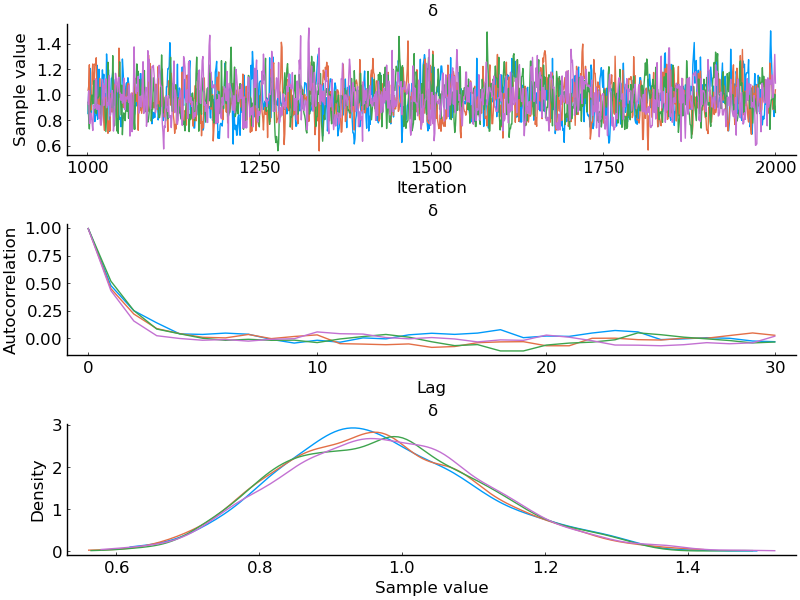

In [9]:
pyplot()
font_size = 12
ch = group(chain, :δ)
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
pcτ = plot(p1, p2, p3, layout=(3,1), size=(800,600))

### Posterior Predictive Distributions

#### Retrieval Failures

The plot below shows the posterior predictive distribution of retrieval failures. The probability of 0 to 2 retrieval failures is approximately $95\$, with 1 retrieval failure being the most likely outcome. More than three retrieval failures is extremrely rare according to the predictions. 

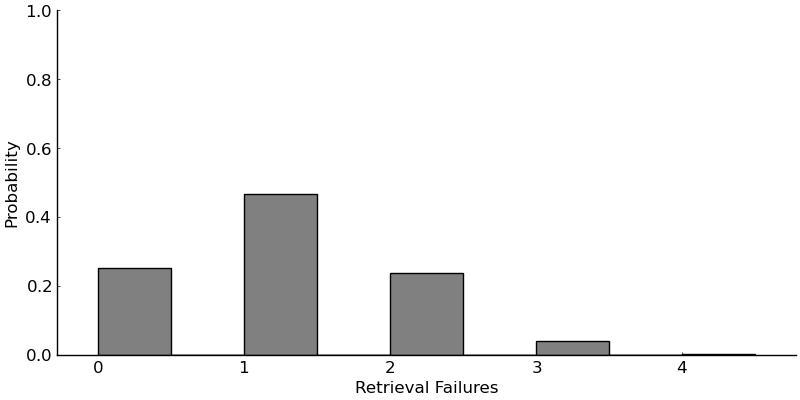

In [10]:
preds = posterior_predictive(x -> simulate(;fixed_parms..., x...), chain, 1000)
failures = n_groups * n_positions .- length.(preds)
p4 = histogram(failures, xaxis=font(12), yaxis=font(12), grid=false, size=(800,400),
    ylims=(0,1), titlefont=font(7), leg=false, color=:grey, xlabel="Retrieval Failures", ylabel="Probability",
    normalize=:probability)